In [1]:
!pip install sentencepiece --quiet
!pip install sacrebleu --quiet
!pip install torchdata --quiet

In [2]:
import math
import os
from dataclasses import dataclass
import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:

def count_lines(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return sum(1 for _ in file)


train_en_file = '/kaggle/input/anlp-a2/train.en'
train_fr_file = '/kaggle/input/anlp-a2/train.fr'
dev_en_file = '/kaggle/input/anlp-a2/dev.en'
dev_fr_file = '/kaggle/input/anlp-a2/dev.fr'
test_en_file = '/kaggle/input/anlp-a2/test.en'
test_fr_file = '/kaggle/input/anlp-a2/test.fr'

print(f"train.en has {count_lines(train_en_file)} lines.")
print(f"train.fr has {count_lines(train_fr_file)} lines.")
print(f"dev.en has {count_lines(dev_en_file)} lines.")
print(f"dev.fr has {count_lines(dev_fr_file)} lines.")
print(f"test.en has {count_lines(test_en_file)} lines.")
print(f"test.fr has {count_lines(test_fr_file)} lines.")


train.en has 30000 lines.
train.fr has 30000 lines.
dev.en has 887 lines.
dev.fr has 887 lines.
test.en has 1305 lines.
test.fr has 1305 lines.


In [4]:
def get_sentence_lengths(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lengths = [len(line.strip().split()) for line in file]
    return lengths

en_lengths = get_sentence_lengths(train_en_file)
fr_lengths = get_sentence_lengths(train_fr_file)

max_en_length = max(en_lengths)
max_fr_length = max(fr_lengths)

percentile_95_en = int(np.percentile(en_lengths, 95))
percentile_95_fr = int(np.percentile(fr_lengths, 95))

print(f"English: Longest Sentence Length = {max_en_length}, 95th Percentile Length = {percentile_95_en}")
print(f"French: Longest Sentence Length = {max_fr_length}, 95th Percentile Length = {percentile_95_fr}")

English: Longest Sentence Length = 609, 95th Percentile Length = 42
French: Longest Sentence Length = 600, 95th Percentile Length = 44


In [5]:
max_seq_len = max(percentile_95_en, percentile_95_fr)
max_seq_len = (max_seq_len + 7) // 8 * 8  # Rounding up to the nearest multiple of 8
print(max_seq_len)

48


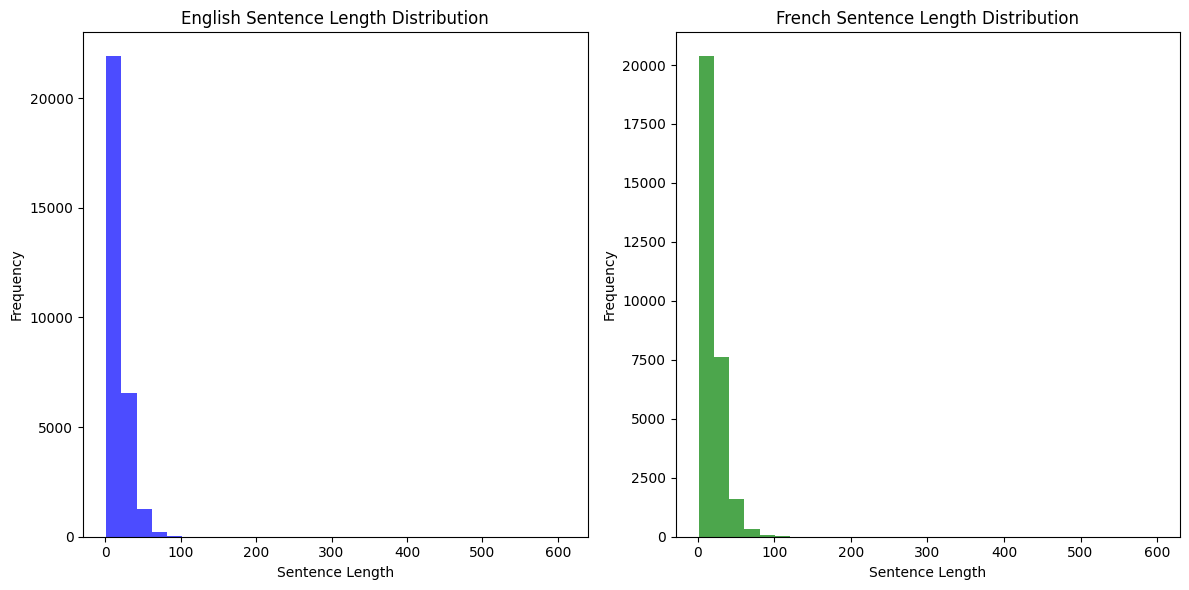

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sentence_length_distribution(en_lengths, fr_lengths):
    plt.figure(figsize=(12, 6))

    
    plt.subplot(1, 2, 1)
    plt.hist(en_lengths, bins=30, color='blue', alpha=0.7)
    plt.title('English Sentence Length Distribution')
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(fr_lengths, bins=30, color='green', alpha=0.7)
    plt.title('French Sentence Length Distribution')
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_sentence_length_distribution(en_lengths, fr_lengths)


In [17]:
en_vocab_size = 8000
fr_vocab_size = 10000
vocab_sizes = {"en": en_vocab_size, "fr": fr_vocab_size}

spm.SentencePieceTrainer.train(
    f'--input={train_en_file} --model_prefix=spm_en --user_defined_symbols=<bos>,<eos>,<pad> --vocab_size={en_vocab_size}')
spm.SentencePieceTrainer.train(
    f'--input={train_fr_file} --model_prefix=spm_fr --user_defined_symbols=<bos>,<eos>,<pad> --vocab_size={fr_vocab_size}')

en_sp = spm.SentencePieceProcessor()
en_sp.load('spm_en.model')
fr_sp = spm.SentencePieceProcessor()
fr_sp.load('spm_fr.model')

tokenizers = {"en": en_sp.encode_as_ids, "fr": fr_sp.encode_as_ids}
detokenizers = {"en": en_sp.decode_ids, "fr": fr_sp.decode_ids}

UNK, BOS, EOS, PAD = 0, 1, 2, 3

def load_data(src_file, tgt_file):
    with open(src_file, 'r', encoding='utf-8') as src_f, open(tgt_file, 'r', encoding='utf-8') as tgt_f:
        data = [(src.strip(), tgt.strip()) for src, tgt in zip(src_f, tgt_f)]
    return data

train_set = load_data(train_en_file, train_fr_file)
valid_set = load_data(dev_en_file, dev_fr_file)
test_set = load_data(test_en_file, test_fr_file)

max_seq_len = 48
def tokenize_dataset(dataset, src_lang, tgt_lang):
    'Tokenize and add BOS and EOS tokens to both source and target sequences'
    return [
        (
            torch.tensor([BOS] + tokenizers[src_lang](src_text)[:max_seq_len-2] + [EOS], dtype=torch.long),
            torch.tensor([BOS] + tokenizers[tgt_lang](tgt_text)[:max_seq_len-2] + [EOS], dtype=torch.long)
        )
        for src_text, tgt_text in dataset
    ]

train_tokenized = tokenize_dataset(train_set, "en", "fr")
valid_tokenized = tokenize_dataset(valid_set, "en", "fr")
test_tokenized = tokenize_dataset(test_set, "en", "fr")

class TranslationDataset(Dataset):
    'Custom Dataset for torch.utils.data.DataLoader()'
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def pad_sequence(batch):
    'Collate function for padding sentences so all sentences in the batch have the same length'
    src_seqs = [src for src, trg in batch]
    trg_seqs = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs, batch_first=True, padding_value=PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs, batch_first=True, padding_value=PAD)
    return src_padded, trg_padded

batch_size = 32

class Dataloaders:
    'Create train_loader, valid_loader, and test_loader for training and evaluation'
    def __init__(self):
        self.train_dataset = TranslationDataset(train_tokenized)
        self.valid_dataset = TranslationDataset(valid_tokenized)
        self.test_dataset = TranslationDataset(test_tokenized)
        
        self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_sequence)
        self.valid_loader = torch.utils.data.DataLoader(self.valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_sequence)
        self.test_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_sequence)

dataloaders = Dataloaders()

for src_batch, tgt_batch in dataloaders.train_loader:
    print("Source batch:", src_batch)
    print("Target batch:", tgt_batch)
    break


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/kaggle/input/anlp-a2/train.en --model_prefix=spm_en --user_defined_symbols=<bos>,<eos>,<pad> --vocab_size=8000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/input/anlp-a2/train.en
  input_format: 
  model_prefix: spm_en
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <bos>
  user_defined_symbols: <eos>
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  

Source batch: tensor([[   1,   52,  192,  ...,    3,    3,    3],
        [   1,   22,   20,  ...,    3,    3,    3],
        [   1,  183,  279,  ...,    6,   19,    2],
        ...,
        [   1,   59, 1420,  ...,    3,    3,    3],
        [   1, 4454, 3359,  ...,    2,    3,    3],
        [   1,   23, 5044,  ...,    3,    3,    3]])
Target batch: tensor([[   1,   64,  197,  ...,    3,    3,    3],
        [   1,   36,   31,  ...,    3,    3,    3],
        [   1,   48, 9443,  ...,  120, 8727,    2],
        ...,
        [   1,  305,   45,  ...,    3,    3,    3],
        [   1, 5763, 5173,  ...,    3,    3,    3],
        [   1, 6325,    6,  ...,    3,    3,    3]])


In [18]:
print(src_batch.shape)
print(tgt_batch.shape)

torch.Size([32, 48])
torch.Size([32, 48])


In [9]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) #to get the batch size
        # Linear projections inorder to get the multi-head query, key and value multidim tensors. 
        # Dimensions of x_query, x_key, x_value: nbatch * seq_len * d_embed.
        # Dimensions of query, key, value: nbatch * h * seq_len * d_k.
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # Attention scores matrix dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # Masking out padding tokens and future tokens wherever necessary
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        #dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        #dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        #dimensions: nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) 


class ResidualConnection(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)
    def forward(self, x, sublayer):
        return x + self.drop(sublayer(self.norm(x)))

# I haven't used fixed positional embeddings but let the model learn the positional embeddings as a learnable parameter.

class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)


class EncoderBlock(nn.Module):
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # First self-attention layer
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # then followed by position-wise fully connected feed-forward NN layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys,values->encoder and Query->decoder
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

In [10]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    d_ff: int
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initializing model parameters using xavier initialization
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

In [11]:
def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [31]:
from numpy.lib.utils import lookfor
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses, acc, count = [], 0, 0
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y)  in  pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        
        if idx>0 and idx%50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}, lr={scheduler.get_last_lr()[0]:.5f}')
    return np.mean(losses)


def train(model, dataloaders, epochs):
    global early_stop_count
    best_valid_loss = float('inf')
    best_epoch = -1  
    best_model_state = None  
    train_size = len(dataloaders.train_loader)*batch_size
    train_losses = []
    valid_losses = []
    for ep in range(epochs):
        train_loss = train_epoch(model, dataloaders)
        valid_loss = validate(model, dataloaders.valid_loader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f'ep: {ep}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = ep
            best_model_state = model.state_dict()
            torch.save(best_model_state, 'best_model.pt')
            print(f'Best model saved with validation loss {best_valid_loss:.5f} at epoch {best_epoch}')
        else:
            if scheduler.last_epoch>2*warmup_steps:
                early_stop_count -= 1
                if early_stop_count<=0:   
                    break
    model.load_state_dict(best_model_state)
    return train_losses, valid_losses,best_epoch
      
               
def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)

In [32]:
def translate(model, x):
#     while inference, translating source sentences into the target language in a auto regressive manner i.e. without looking at actual ground truth and relying on previous token generated only.
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

In [33]:
def remove_pad(sent):
    if sent.count(EOS)>0:
        sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))] 
            if num_batch and idx>=num_batch:
                break
        print(min([len(x) for x in refs]))
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

In [34]:
SRC = "en"
TRG = "fr"

In [35]:
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC], 
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=768, 
                     d_ff=2028, 
                     h=8,
                     N_encoder=3, 
                     N_decoder=3, 
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )

data_loaders = Dataloaders()
train_size = len(data_loaders.train_loader)*batch_size
model = make_model(config)
model_size = sum([p.numel() for p in model.parameters()])
print(f'model_size: {model_size}, train_set_size: {train_size}')
warmup_steps = 3*len(data_loaders.train_loader)
# lr increases during the warmup steps and then descreases accordingly
lr_fn = lambda step: config.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.95), eps=1.0e-8)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
early_stop_count = 2
train_losses, valid_losses,best_epoch = train(model, data_loaders, epochs=15)
test_loss  = validate(model, data_loaders.test_loader)
best_train_loss = train_losses[best_epoch]
best_valid_loss = valid_losses[best_epoch]
best_test_loss = validate(model, data_loaders.test_loader)
print("train set examples:")
train_bleu = evaluate(model, data_loaders.train_loader, 20)
print("validation set examples:")
valid_bleu = evaluate(model, data_loaders.valid_loader)
print("test set examples:")
test_bleu  = evaluate(model, data_loaders.test_loader)
print(f'train_loss: {best_train_loss:.4f}, valid_loss: {best_valid_loss:.4f}, test_loss: {best_test_loss:.4f}')
print(f'test_bleu: {test_bleu:.4f}, valid_bleu: {valid_bleu:.4f} train_bleu: {train_bleu:.4f}')

model_size: 61581976, train_set_size: 30016


train loss=4.551, lr=0.00011: 100%|██████████| 938/938 [02:21<00:00,  6.64it/s]


ep: 0: train_loss=5.89345, valid_loss=4.88865
Best model saved with validation loss 4.88865 at epoch 0


train loss=4.085, lr=0.00022: 100%|██████████| 938/938 [02:21<00:00,  6.63it/s]


ep: 1: train_loss=4.11294, valid_loss=4.11211
Best model saved with validation loss 4.11211 at epoch 1


train loss=3.069, lr=0.00034: 100%|██████████| 938/938 [02:21<00:00,  6.64it/s]


ep: 2: train_loss=3.34079, valid_loss=3.66736
Best model saved with validation loss 3.66736 at epoch 2


train loss=2.438, lr=0.00030: 100%|██████████| 938/938 [02:21<00:00,  6.64it/s]


ep: 3: train_loss=2.75884, valid_loss=3.34262
Best model saved with validation loss 3.34262 at epoch 3


train loss=2.271, lr=0.00026: 100%|██████████| 938/938 [02:21<00:00,  6.64it/s]


ep: 4: train_loss=2.29673, valid_loss=3.21419
Best model saved with validation loss 3.21419 at epoch 4


train loss=2.020, lr=0.00024: 100%|██████████| 938/938 [02:21<00:00,  6.65it/s]


ep: 5: train_loss=1.96648, valid_loss=3.14930
Best model saved with validation loss 3.14930 at epoch 5


train loss=2.028, lr=0.00022: 100%|██████████| 938/938 [02:21<00:00,  6.65it/s]


ep: 6: train_loss=1.71071, valid_loss=3.13797
Best model saved with validation loss 3.13797 at epoch 6


train loss=1.624, lr=0.00021: 100%|██████████| 938/938 [02:21<00:00,  6.65it/s]


ep: 7: train_loss=1.49612, valid_loss=3.17978


train loss=1.476, lr=0.00020: 100%|██████████| 938/938 [02:21<00:00,  6.65it/s]


ep: 8: train_loss=1.31072, valid_loss=3.23492
train set examples:
5
src:  I'm the Ted Bundy of string theory.
trg:  Je suis le Ted Bundy de la théorie des cordes.
pred: Je suis le Bundidy de la théorie des cordes.
src:  You want people to use clean needles -- and junkies want to use clean needles.
trg:  On veut que les gens utilisent des seringues propres, et les drogués veulent utiliser des seringues propres.
pred: Vous voulez que les gens utilisent des seringues propres, et les drogués veulent utiliser des seringues propres.
src:  And I think, in many ways, the idea of resilience is a more useful concept than the idea of sustainability.
trg:  Et je pense que, de bien des façons, l'idée de résilience est un concept plus utile que celle de durabilité.
pred: Et je pense que, de nombreuses manières, l'idée de résilience est un concept plus utile que l'idée de durabilité.
validation set examples:
5
src:  So, the last example I have time to show you today is a music sequencing and live per

In [38]:
def translate_this_sentence(text: str):
    'translate the source sentence in string formate into target language'
    input = torch.tensor([[BOS] + tokenizers[SRC](text) + [EOS]]).to(DEVICE)
    output = translate(model, input)
    return decode_sentence(detokenizers[TRG], output[0])

translate_this_sentence("What do you do for a living?")

'Que font-vous pour un vie?'

In [37]:
def evaluate_and_save_bleu(model, dataloader, filename='testbleu.txt', num_batch=None):
    model.eval()
    refs, cans, bleus = [], [], []
    
    with open(filename, 'w') as f:
        with torch.no_grad():
            for idx, (x, y) in enumerate(dataloader):
                src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
                
                translation = translate(model, src)
                
                trg_out = trg_out.view(x.size(0), -1)
                
                for i in range(len(src)):
                    ref_sentence = decode_sentence(detokenizers[TRG], trg_out[i])
                    gen_sentence = decode_sentence(detokenizers[TRG], translation[i])
                    
                    bleu_score = sacrebleu.corpus_bleu([gen_sentence], [[ref_sentence]]).score
                    
                    f.write(f"{gen_sentence} {bleu_score:.2f}\n")
                    
                    refs.append(ref_sentence)
                    cans.append(gen_sentence)
                
                if num_batch and idx >= num_batch:
                    break
            
            overall_bleu_score = sacrebleu.corpus_bleu(cans, [refs]).score
            
            print(f"Overall BLEU score: {overall_bleu_score:.2f}")
            print(f"BLEU scores for individual sentences saved to {filename}")

            for i in range(min(3, len(src))):
                print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
                print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
                print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
            
            return overall_bleu_score

evaluate_and_save_bleu(model, data_loaders.test_loader, filename='testbleu.txt')


Overall BLEU score: 18.08
BLEU scores for individual sentences saved to testbleu.txt
src:  It also means tomorrow, after a day and a night.
trg:  Ça veut aussi dire demain, après un jour et une nuit.
pred: Ça veut aussi dire demain après un jour et une nuit.
src:  The sun is coming up above the horizon. Sunrise.
trg:  Le soleil se lève au-dessus de l'horizon. L'aube.
pred: Le soleil sort de l'horizon. Autor de l'horizon.
src:  A door. Put a plank inside the door, it's a door bolt.
trg:  Une porte. Une planche dans la porte, c'est un verrou.
pred: Un porte-uncapide. Mets une planche à l'intérieur, c'est une porte de porte.


18.081412482397795


=== Hyperparameter Combination 1 ===
Params: {'d_embed': 256, 'd_ff': 512, 'h': 4, 'N_encoder': 2, 'N_decoder': 2, 'dropout': 0.1}
Model size: 9839376
Training model...


train loss=5.104, lr=0.00019: 100%|██████████| 938/938 [00:22<00:00, 41.08it/s]


ep: 0: train_loss=6.56844, valid_loss=5.25403


train loss=4.387, lr=0.00039: 100%|██████████| 938/938 [00:22<00:00, 41.34it/s]


ep: 1: train_loss=4.46037, valid_loss=4.39420


train loss=3.432, lr=0.00058: 100%|██████████| 938/938 [00:22<00:00, 40.95it/s]


ep: 2: train_loss=3.69894, valid_loss=3.93894


train loss=3.052, lr=0.00051: 100%|██████████| 938/938 [00:23<00:00, 40.71it/s]


ep: 3: train_loss=3.16050, valid_loss=3.61528


train loss=2.574, lr=0.00046: 100%|██████████| 938/938 [00:23<00:00, 40.56it/s]


ep: 4: train_loss=2.73814, valid_loss=3.43509


train loss=2.317, lr=0.00042: 100%|██████████| 938/938 [00:23<00:00, 40.25it/s]


ep: 5: train_loss=2.44787, valid_loss=3.31756


train loss=2.149, lr=0.00039: 100%|██████████| 938/938 [00:23<00:00, 40.33it/s]


ep: 6: train_loss=2.23830, valid_loss=3.28685


train loss=2.320, lr=0.00036: 100%|██████████| 938/938 [00:23<00:00, 40.04it/s]


ep: 7: train_loss=2.07803, valid_loss=3.29460
Evaluating BLEU score on train, validation, and test sets...
6
src:  In fact, Solly gave her the name Elvis because he said she walked like she was doing the Elvis the pelvis dance.
trg:  En fait, c'est Solly qui lui a donné le nom d'Elvis, car il disait qu'elle marchait comme si elle faisait la danse d'Elvis le pelvis.
pred: En fait, Solly a donné son nom au nom de l'honneur parce qu'elle faisait comme elle opérer son Kavita Ramdas.
src:  But for so many of us, it doesn't work in our lives.
trg:  Mais, pour beaucoup d'entre nous, ça ne marche pas dans nos vies.
pred: Mais pour tant de nous, ça ne marche pas dans nos vies.
src:  This is Vancouver's propaganda about how green a city they are.
trg:  C'est la publicité de Vancouver pour dire comme leur ville est verte.
pred: C'est Vrépul de la manière dont la ville vert sont vertes.
5
src:  So, the last example I have time to show you today is a music sequencing and live performance tool that 

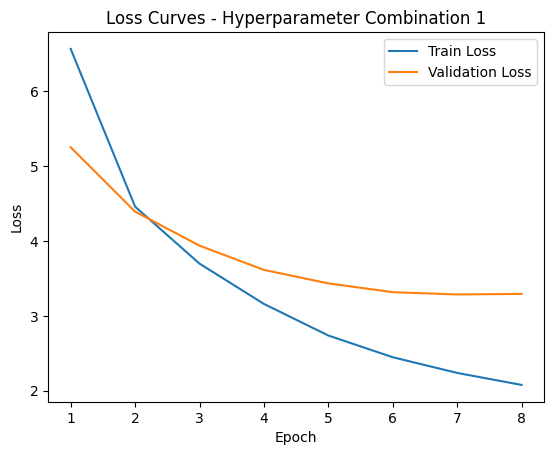


=== Hyperparameter Combination 2 ===
Params: {'d_embed': 512, 'd_ff': 512, 'h': 8, 'N_encoder': 2, 'N_decoder': 2, 'dropout': 0.1}
Model size: 22812432
Training model...


train loss=4.656, lr=0.00013: 100%|██████████| 938/938 [00:45<00:00, 20.44it/s]


ep: 0: train_loss=6.20334, valid_loss=5.01468


train loss=3.964, lr=0.00027: 100%|██████████| 938/938 [00:46<00:00, 20.33it/s]


ep: 1: train_loss=4.23740, valid_loss=4.21574


train loss=3.577, lr=0.00041: 100%|██████████| 938/938 [00:46<00:00, 20.30it/s]


ep: 2: train_loss=3.47994, valid_loss=3.77077


train loss=2.649, lr=0.00036: 100%|██████████| 938/938 [00:46<00:00, 20.10it/s]


ep: 3: train_loss=2.90391, valid_loss=3.45636


train loss=2.499, lr=0.00032: 100%|██████████| 938/938 [00:46<00:00, 20.13it/s]


ep: 4: train_loss=2.43592, valid_loss=3.30209


train loss=2.132, lr=0.00030: 100%|██████████| 938/938 [00:46<00:00, 20.11it/s]


ep: 5: train_loss=2.10999, valid_loss=3.23514


train loss=1.888, lr=0.00027: 100%|██████████| 938/938 [00:46<00:00, 20.09it/s]


ep: 6: train_loss=1.86364, valid_loss=3.24693
Evaluating BLEU score on train, validation, and test sets...
5
src:  Google enriches itself by enriching thousands of bloggers through AdSense.
trg:  Goggle s'enrichit lui-même tout en enrichissant des milliers de blogueur à travers AdSense.
pred: Google rus-mêmes en ruçant des milliers de blogs à travers Asides.
src:  So for those that still believe that this is science fiction, I firmly say to you that it is not.
trg:  Alors, pour ceux qui pensent encore que c'est de la science-fiction, je suis catégorique sur le fait que ça ne l'est pas.
pred: Pour ceux qui croient toujours que c'est la science de la science, je vous dis que c'est pas.
src:  You know, you find somebody who is respectable and has a lot of money.
trg:  Vous voyez, vous trouvez quelqu'un qui est respectable et qui a beaucoup d'argent.
pred: Vous savez, vous trouvez quelqu'un qui est respectable et a beaucoup d'argent.
5
src:  So, the last example I have time to show you tod

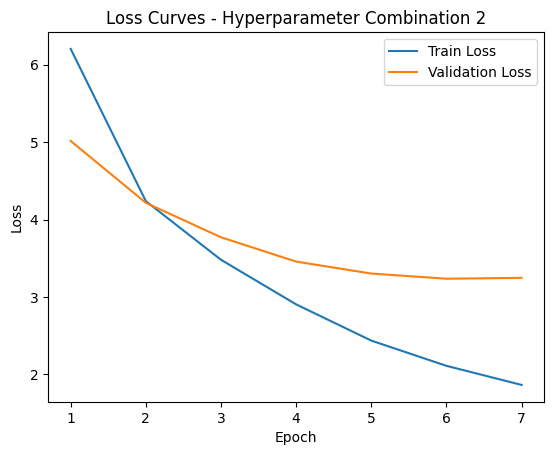


=== Hyperparameter Combination 3 ===
Params: {'d_embed': 512, 'd_ff': 1024, 'h': 8, 'N_encoder': 3, 'N_decoder': 3, 'dropout': 0.2}
Model size: 30168848
Training model...


train loss=4.830, lr=0.00013: 100%|██████████| 938/938 [01:09<00:00, 13.54it/s]


ep: 0: train_loss=6.26480, valid_loss=5.15267


train loss=4.219, lr=0.00027: 100%|██████████| 938/938 [01:09<00:00, 13.51it/s]


ep: 1: train_loss=4.45086, valid_loss=4.39108


train loss=3.339, lr=0.00041: 100%|██████████| 938/938 [01:09<00:00, 13.52it/s]


ep: 2: train_loss=3.73993, valid_loss=3.92941


train loss=3.181, lr=0.00036: 100%|██████████| 938/938 [01:09<00:00, 13.53it/s]


ep: 3: train_loss=3.20439, valid_loss=3.62613


train loss=2.811, lr=0.00032: 100%|██████████| 938/938 [01:09<00:00, 13.51it/s]


ep: 4: train_loss=2.80018, valid_loss=3.46038


train loss=2.217, lr=0.00030: 100%|██████████| 938/938 [01:09<00:00, 13.54it/s]


ep: 5: train_loss=2.51484, valid_loss=3.36361


train loss=2.406, lr=0.00027: 100%|██████████| 938/938 [01:09<00:00, 13.49it/s]


ep: 6: train_loss=2.29991, valid_loss=3.31484


train loss=2.266, lr=0.00026: 100%|██████████| 938/938 [01:09<00:00, 13.50it/s]


ep: 7: train_loss=2.13054, valid_loss=3.25807


train loss=1.981, lr=0.00024: 100%|██████████| 938/938 [01:09<00:00, 13.52it/s]


ep: 8: train_loss=1.99226, valid_loss=3.25231


train loss=1.991, lr=0.00023: 100%|██████████| 938/938 [01:09<00:00, 13.51it/s]


ep: 9: train_loss=1.87545, valid_loss=3.21874


train loss=2.017, lr=0.00022: 100%|██████████| 938/938 [01:09<00:00, 13.52it/s]


ep: 10: train_loss=1.77343, valid_loss=3.22588
Evaluating BLEU score on train, validation, and test sets...
4
src:  You just need to take small steps, accumulate small wins, keep reaching for that green stick.
trg:  On a juste besoin de faire de petits pas, d'accumuler de petites victoires, de continuer à chercher ce petit bâton vert.
pred: Vous avez juste besoin de prendre des petits pas, d'accumuler de petits pas, de continuer à réaliser à courir.
src:  And this is my son working with me on a small fast-food thing.
trg:  Et voici mon fils qui travaille avec moi sur ce petit projet fast-food.
pred: Et c'est mon fils qui travaille avec moi sur un petit truc rapide.
src:  There is nothing on the other side.
trg:  Il n'y a rien de l'autre coté.
pred: Il n'y a rien sur l'autre côté.
5
src:  So, the last example I have time to show you today is a music sequencing and live performance tool that we've built recently, in which Siftables act as sounds like lead, bass and drums.
trg:  Le dernie

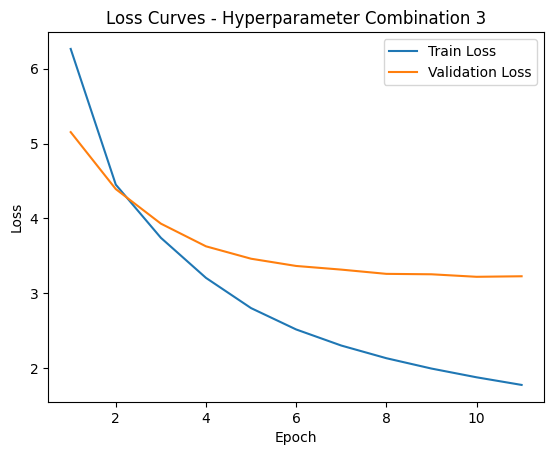


=== Hyperparameter Combination 4 ===
Params: {'d_embed': 768, 'd_ff': 2048, 'h': 8, 'N_encoder': 3, 'N_decoder': 3, 'dropout': 0.2}
Model size: 61766416
Training model...


train loss=4.878, lr=0.00011: 100%|██████████| 938/938 [02:20<00:00,  6.66it/s]


ep: 0: train_loss=6.02513, valid_loss=5.00936


train loss=4.105, lr=0.00022: 100%|██████████| 938/938 [02:20<00:00,  6.66it/s]


ep: 1: train_loss=4.29145, valid_loss=4.26843


train loss=3.675, lr=0.00034: 100%|██████████| 938/938 [02:21<00:00,  6.65it/s]


ep: 2: train_loss=3.58205, valid_loss=3.84302


train loss=2.770, lr=0.00030: 100%|██████████| 938/938 [02:20<00:00,  6.66it/s]


ep: 3: train_loss=3.05465, valid_loss=3.53169


train loss=2.966, lr=0.00026: 100%|██████████| 938/938 [02:20<00:00,  6.66it/s]


ep: 4: train_loss=2.63790, valid_loss=3.36459


train loss=2.401, lr=0.00024: 100%|██████████| 938/938 [02:20<00:00,  6.67it/s]


ep: 5: train_loss=2.34329, valid_loss=3.26095


train loss=1.963, lr=0.00022: 100%|██████████| 938/938 [02:20<00:00,  6.67it/s]


ep: 6: train_loss=2.11936, valid_loss=3.22599


train loss=1.778, lr=0.00021: 100%|██████████| 938/938 [02:20<00:00,  6.66it/s]


ep: 7: train_loss=1.94399, valid_loss=3.19647


train loss=2.125, lr=0.00020: 100%|██████████| 938/938 [02:20<00:00,  6.66it/s]


ep: 8: train_loss=1.79535, valid_loss=3.19768
Evaluating BLEU score on train, validation, and test sets...
4
src:  And this guy has to come to the net.
trg:  Et ce gars doit aller au filet.
pred: Ce type doit aller au filet.
src:  That would not work.
trg:  Cela ne marcherait pas.
pred: Cela ne marcherait pas.
src:  <description>TED Talk Subtitles and Transcript: Every day, in a city the size of London, 30 million meals are served. But where does all the food come from? Architect Carolyn
trg:  <description>TED Talk Subtitles and Transcript: Chaque jour, dans une ville de la taille de Londres, 30 millions de repas sont servis. Mais d'où vient toute cette nourriture ? L'architecte C
pred: <description>TED Talk Subtitles and Transcript: Chaque jour, dans une ville de la taille de Londres, 30 millions de repas sont servis. Mais où tout est-ce que tout ça vient de la nourriture
5
src:  So, the last example I have time to show you today is a music sequencing and live performance tool that we

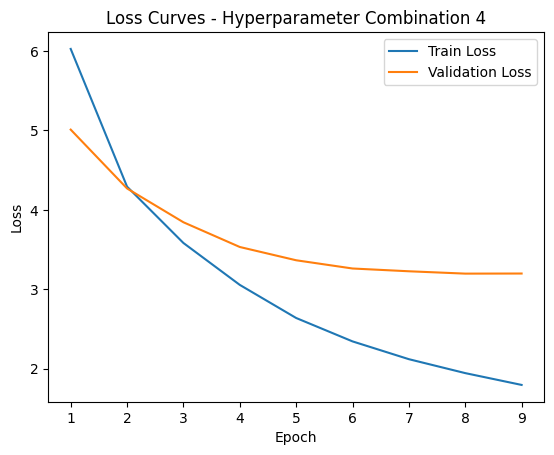


=== Hyperparameter Combination 5 ===
Params: {'d_embed': 768, 'd_ff': 2048, 'h': 8, 'N_encoder': 4, 'N_decoder': 4, 'dropout': 0.1}
Model size: 75158288
Training model...


train loss=4.767, lr=0.00011: 100%|██████████| 938/938 [03:00<00:00,  5.20it/s]


ep: 0: train_loss=5.89511, valid_loss=4.91025


train loss=3.892, lr=0.00022: 100%|██████████| 938/938 [03:00<00:00,  5.19it/s]


ep: 1: train_loss=4.17828, valid_loss=4.17643


train loss=3.418, lr=0.00034: 100%|██████████| 938/938 [03:00<00:00,  5.19it/s]


ep: 2: train_loss=3.41353, valid_loss=3.74298


train loss=2.665, lr=0.00030: 100%|██████████| 938/938 [03:00<00:00,  5.20it/s]


ep: 3: train_loss=2.83446, valid_loss=3.41634


train loss=2.321, lr=0.00026: 100%|██████████| 938/938 [03:00<00:00,  5.21it/s]


ep: 4: train_loss=2.37499, valid_loss=3.24705


train loss=2.228, lr=0.00024: 100%|██████████| 938/938 [03:00<00:00,  5.20it/s]


ep: 5: train_loss=2.05103, valid_loss=3.19336


train loss=1.816, lr=0.00022: 100%|██████████| 938/938 [03:00<00:00,  5.20it/s]


ep: 6: train_loss=1.79613, valid_loss=3.19283


train loss=1.636, lr=0.00021: 100%|██████████| 938/938 [03:00<00:00,  5.20it/s]


ep: 7: train_loss=1.58496, valid_loss=3.19759
Evaluating BLEU score on train, validation, and test sets...
6
src:  And there are a couple of these that have strong predictive relationships, one of which is education, where you see the states with the fewest years of schooling per adult are in red, and you see this part of the
trg:  Et il y en a une ou deux qui ont de fortes relations de prédiction l'une étant l'éducation. Là où vous voyez les états qui ont la durée de scolarisation la plus courte par adulte, sont en rouge
pred: Et il y a deux de ces relations de prédisantes qui sont de relations de forte, dont l'éducation, où l'on voit les états avec les plus de quelques années de l'école de l'
src:  And so, I fused together the two things I loved the most, which was skiing and windsurfing.
trg:  Et donc, j'ai fait fusionner les deux choses que j'aimais le plus, c'est-à-dire le ski et la planche à voile.
pred: Et donc, j'ai fait fusionner les deux choses que j'aime la plupart des chose

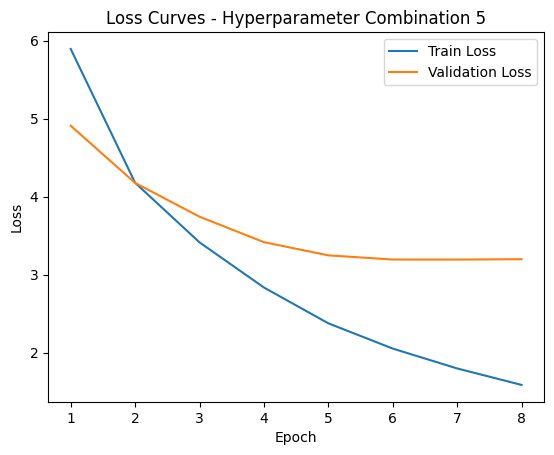

In [30]:
import matplotlib.pyplot as plt

hyperparams_list = [
    {'d_embed': 256, 'd_ff': 512, 'h': 4, 'N_encoder': 2, 'N_decoder': 2, 'dropout': 0.1},
    {'d_embed': 512, 'd_ff': 512, 'h': 8, 'N_encoder': 2, 'N_decoder': 2, 'dropout': 0.1},
    {'d_embed': 512, 'd_ff': 1024, 'h': 8, 'N_encoder': 3, 'N_decoder': 3, 'dropout': 0.2},
    {'d_embed': 768, 'd_ff': 2048, 'h': 8, 'N_encoder': 3, 'N_decoder': 3, 'dropout': 0.2},
    {'d_embed': 768, 'd_ff': 2048, 'h': 8, 'N_encoder': 4, 'N_decoder': 4, 'dropout': 0.1}    
]

results = []

for i, params in enumerate(hyperparams_list):
    print(f"\n=== Hyperparameter Combination {i+1} ===")
    print(f"Params: {params}")

    config = ModelConfig(
        encoder_vocab_size=vocab_sizes[SRC],
        decoder_vocab_size=vocab_sizes[TRG],
        d_embed=params['d_embed'],
        d_ff=params['d_ff'],
        h=params['h'],
        N_encoder=params['N_encoder'],
        N_decoder=params['N_decoder'],
        max_seq_len=max_seq_len,
        dropout=params['dropout']
    )

    model = make_model(config)
    model_size = sum([p.numel() for p in model.parameters()])
    print(f'Model size: {model_size}')

    warmup_steps = 3 * len(data_loaders.train_loader)
    lr_fn = lambda step: config.d_embed**(-0.5) * min([(step + 1)**(-0.5), (step + 1) * warmup_steps**(-1.5)])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)

    print("Training model...")
    train_losses, valid_losses,best_epoch = train(model, data_loaders, epochs=15)
    test_loss  = validate(model, data_loaders.test_loader)
    best_train_loss = train_losses[best_epoch]
    best_valid_loss = valid_losses[best_epoch]
    best_test_loss = validate(model, data_loaders.test_loader)

    print("Evaluating BLEU score on train, validation, and test sets...")
    train_bleu = evaluate(model, data_loaders.train_loader, 20)
    valid_bleu = evaluate(model, data_loaders.valid_loader)
    test_bleu = evaluate(model, data_loaders.test_loader)

    print(f'train_loss: { best_train_loss:.4f}, valid_loss: {best_valid_loss:.4f}, test_loss: {best_test_loss:.4f}')
    print(f'test_bleu: {test_bleu:.4f}, valid_bleu: {valid_bleu:.4f}, train_bleu: {train_bleu:.4f}')

    results.append({
        'params': params,
        'train_loss': train_losses,
        'valid_loss': valid_losses,
        'test_loss': test_loss,
        'train_bleu': train_bleu,
        'valid_bleu': valid_bleu,
        'test_bleu': test_bleu
    })

    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss Curves - Hyperparameter Combination {i+1}")
    plt.legend()
    plt.show()

    print("=============================================")
